# <span style="color:#F72585">Predicción del valor de una acción a un día. Apple (LSTM)</span>

Con dropout

## <span style="color:#4361EE">Importar las librería requeridas</span>

In [33]:

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn.preprocessing import MinMaxScaler

# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
print("Versión de Tensorflow: ", tf.__version__)

# optimizador
from tensorflow.keras.optimizers import Adam

Versión de Tensorflow:  2.9.1


## <span style="color:#4361EE">Lectura de  los datos</span>

Estos datos corresponden a la empresa *Apple*. Son  3019 datos que corresponden a observaciones del precio de la acción, el número de transacciones de la acción (compra-venta). Los datos son diarios (dias hábiles o comerciales). Están entre el 3 de enero de 2006 hasta el 1 de enero de 2018.

la columna *Date* es la fecha, *Open* es el valor de acción a la apertura del mercado, *High* el valor más alto alcanzado en el día, *Low* el valor más bajo del día, *Close* el valor al cierre,  *Volume* es el volúmenes de acciones transadas en el día  y *Name* es el código de identificación de la empresa, Apple en este caso.


Los datos puede ser bajados directamente de [Kaggle](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231)

In [34]:
#reading from a local file

df = pd.read_csv('https://raw.githubusercontent.com/AprendizajeProfundo/Libro-Fundamentos/main/Redes_Recurrentes/Datos/AAPL_2006-01-01_to_2018-01-01.csv')


In [35]:
# looking at the first five rows of the data
print('\n Shape of the data:')
print(df.shape)
df.head()


 Shape of the data:
(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


Vamos a cambiar el índice de los datos. Tomaremos la fecha como indice: *df.index*. Los datos se reordenan para invertir la tabla, debido a que los datos contienen las observaciones más recientes en la parte superior de la tabla.

## <span style="color:#4361EE">Extrae datos para la serie que se desea predecir-close</span>

In [36]:
#creating dataframe with date and the target variable

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
# df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(df[['Date', 'Close']])
#
#setting index
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
data.head()

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86


## <span style="color:#4361EE">Visualización de la serie precio al cierre</span>

In [37]:
# plot
len_data = len(data)
len_train = int(len_data*0.8) # 80%  = 2415
len_test = len_data- len_train # 20% = 604
print (len_data, '=', len_train, '+',len_test)

3019 = 2415 + 604


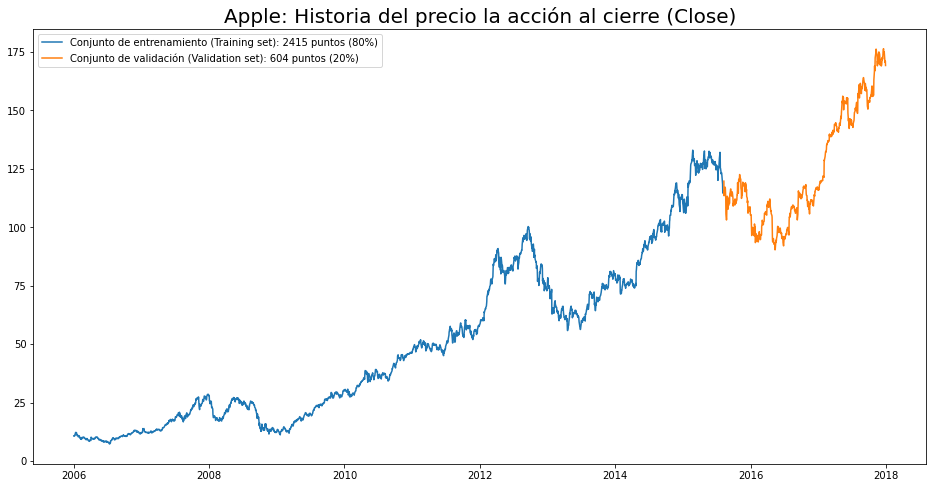

In [38]:
plt.figure(figsize=(16,8))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data['Close'][len_train:], label='Conjunto de validación (Validation set): {} puntos (20%)'.format(len_test)) 
plt.title("Apple: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

## <span style="color:#4361EE">Preparación de los datos para el entrenamiento de la red LSTM</span>

Para evitar problemas con las tendencias y para mejorar la estimación (entrenamiento) los datos se van a transformar a la escala $[0,1]$. Para las predicciones se utiliza la transformación inversa.

### <span style="color:#4CC9F0">Primero extrae los valores y se crea el  objeto MinMaxScaler</span>

In [39]:
#creating train and test sets
dataset = data.values


# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = np.array(scaler.fit_transform(dataset))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)),axis=1)
# dataset = pd.DataFrame(scaled_data,index=data.index, columns=['serie'])

In [40]:
dataset.shape

(3019,)

### <span style="color:#4CC9F0">Crea datos de entrenamiento</span>


 La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 5 datos (la predicción a
 partir de esos "time_step" datos se hace para los siguentes 5 días). Se conformará de esta forma el set de entrenamiento

1. Número de datos consecutivos para entrenamiento: time_step = 60. 
2. Días a predecir: days = 1

### <span style="color:#4CC9F0">Función para crear los datos de entrenamiento</span>


In [41]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    ''' dataset: conjunto de datos
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la ventana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])

    return np.array(data), np.array(labels)

Se coloca una semilla para garantizar reproductibidad dentre de tensorflow

In [42]:
tf.random.set_seed(500)

In [43]:
#
# hiperparámetros para crear las secuencias
past_history = 60 # tamaño secuencias de entrada
future_target = 1 # días adelante
TRAIN_SPLIT = int(len_data*0.8) #2415: nuḿero de datos entrenamiento

# secuencias de entrenamiento
X_train, y_train = univariate_data(dataset, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
#
#secuencias de validación
# No se usará ningún dato que el modelo haya visto
X_test, y_test = univariate_data(dataset, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

2415
(2355, 60, 1)
(2355,)
(543, 60, 1)
(543,)


In [44]:
print ('Ventana  de la historia pasada')
print (X_train[1])
print ('\n Valor de la acción a predecir')
print (y_train[1])

Ventana  de la historia pasada
[[0.0205107 ]
 [0.02003783]
 [0.02163376]
 [0.02139733]
 [0.02547582]
 [0.0280766 ]
 [0.02837215]
 [0.02949521]
 [0.0287268 ]
 [0.02683532]
 [0.023939  ]
 [0.02145644]
 [0.02281594]
 [0.02139733]
 [0.0198605 ]
 [0.01826457]
 [0.01802814]
 [0.0205107 ]
 [0.02098357]
 [0.02086535]
 [0.01808724]
 [0.01785081]
 [0.01400875]
 [0.01430429]
 [0.01530914]
 [0.01205816]
 [0.01406786]
 [0.01182173]
 [0.01430429]
 [0.01566379]
 [0.01678685]
 [0.01655042]
 [0.01554557]
 [0.01743705]
 [0.0177917 ]
 [0.01755527]
 [0.01714151]
 [0.01501359]
 [0.01554557]
 [0.01595933]
 [0.0143634 ]
 [0.01247192]
 [0.01318123]
 [0.01264925]
 [0.01117153]
 [0.01058045]
 [0.01264925]
 [0.01406786]
 [0.01312212]
 [0.01152619]
 [0.01182173]
 [0.01123064]
 [0.00939827]
 [0.00928006]
 [0.00797967]
 [0.00786145]
 [0.00744769]
 [0.00679749]
 [0.00981203]
 [0.01016669]]

 Valor de la acción a predecir
0.010107577727863803


## <span style="color:#4361EE">Crea el modelo LSTM</span>

In [45]:
# shapes
input_shape = (X_train.shape[1], X_train.shape[2])
units = 50

# layers
inputs = Input(input_shape)
x = Dropout(0.2, name= 'Dropout_01')(inputs)
x = LSTM(units=units, name='LSTM_layer')(x)
#x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
#x = Dropout(0.4)
#x = LSTM(units=units//2, name='LSTM_layer_2')(x)
#x = Dropout(0.4)
x = Dropout(0.2, name= 'Dropout_02')(x)
outputs = Dense(1)(x)

# model
model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_01.summary()


Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 Dropout_01 (Dropout)        (None, 60, 1)             0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


### <span style="color:#4CC9F0">Compila</span>

Se usará el optimizador Adam y la función de pérdida MSE

In [46]:
model_01.compile(loss='mean_squared_error',
  optimizer=Adam(0.001))


### <span style="color:#4CC9F0">Entrena el modelo</span>

In [47]:
#history = model_01.fit(X_train,y_train,epochs=20,batch_size=32)
history = model_01.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/10
67/67 [==============================] - 5s 35ms/step - loss: 0.0036 - val_loss: 0.0123
Epoch 2/10
67/67 [==============================] - 2s 24ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 3/10
67/67 [==============================] - 2s 25ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 4/10
67/67 [==============================] - 2s 24ms/step - loss: 0.0025 - val_loss: 6.0377e-04
Epoch 5/10
67/67 [==============================] - 2s 26ms/step - loss: 0.0029 - val_loss: 6.3398e-04
Epoch 6/10
67/67 [==============================] - 2s 26ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 7/10
67/67 [==============================] - 2s 24ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 8/10
67/67 [==============================] - 2s 25ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 9/10
67/67 [==============================] - 2s 27ms/step - loss: 0.0028 - val_loss: 8.1421e-04
Epoch 10/10
67/67 [==============================] - 2s 25ms/step - loss: 0.0024 - val_loss: 8.36

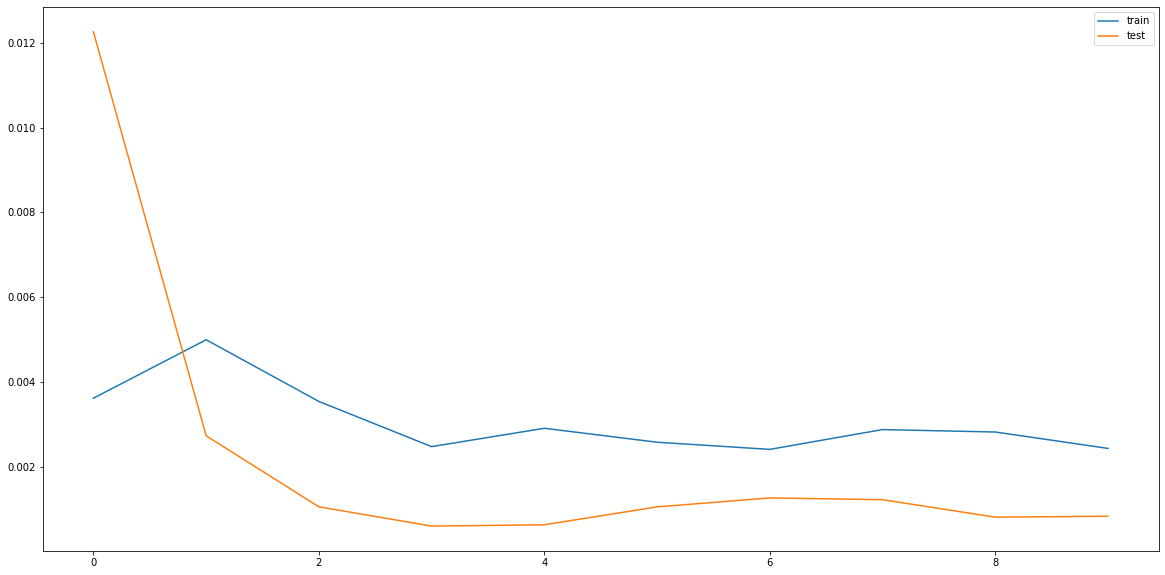

In [48]:
plt.plot(history.history['loss'][:], label='train')
plt.plot(history.history['val_loss'][:], label='test')
plt.legend();

## <span style="color:#4361EE">Predicciones</span>

### <span style="color:#4CC9F0">Prepara los datos de validación</span>


In [49]:
X_test.shape

(543, 60, 1)

### <span style="color:#4CC9F0">Calcula predicciones</span>


In [50]:
# predictions
prediction1 = model_01.predict(X_test)
#prediction = scaler.inverse_transform(prediction)

17/17 [==============================] - 1s 9ms/step


In [51]:
print(prediction1.shape)
print(y_test.shape)


(543, 1)
(543,)


### <span style="color:#4CC9F0">Elimina dimensiones sobrantes para los gráficos</span>


In [52]:
y_train_p1 = y_train #np.squeeze(y_train, axis=-1)
y_test_p1 = y_test#np.squeeze(y_test, axis=-1)
y_pred_p1 = np.squeeze(prediction1, axis=-1)

In [53]:
print(y_train_p1.shape)
print(y_test_p1.shape)
print(y_pred_p1.shape)

k=0
for i,j in zip(y_test_p1, y_pred_p1):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

(2355,)
(543,)
(543,)
0.6783307719588605 0.637711 0.04061978343728456
0.6719470386570517 0.64086896 0.03107807684598607
0.6727745596406196 0.64351714 0.029257423066828103
0.6698782361981322 0.64548534 0.02439289464921257
0.6474169523584349 0.64730024 0.000116708980749336
0.6435157820073296 0.6487008 -0.005184991708643283
0.6412105449816764 0.6483837 -0.007173132024091422
0.6212318240926825 0.6477511 -0.026519268818084085
0.6321078141624307 0.64690495 -0.014797131211104486
0.6292114907199433 0.64466983 -0.015458340079159472


### <span style="color:#4CC9F0">Gráfica de las predicciones</span>


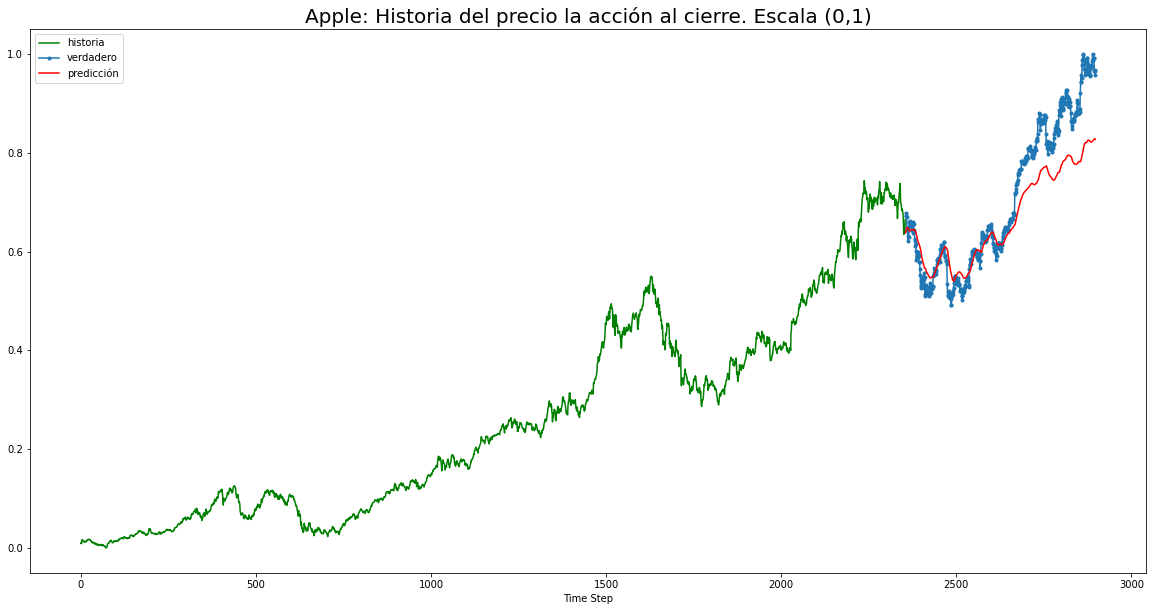

In [54]:
plt.plot(np.arange(0, len(y_train_p1)), y_train_p1, 'g', label="historia")
plt.plot(np.arange(len(y_train_p1), len(y_train_p1) + len(y_test_p1)), y_test_p1, marker='.', label="verdadero")
plt.plot(np.arange(len(y_train_p1), len(y_train_p1) + len(y_test_p1)), y_pred_p1, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Apple: Historia del precio la acción al cierre. Escala (0,1)", size = 20)
plt.legend()
plt.show();

### <span style="color:#4CC9F0">Regreso a la escala original</span>


In [55]:
y_pred_or1 = scaler.inverse_transform(y_pred_p1.reshape(-1,1))
y_test_or1 = scaler.inverse_transform(y_test_p1.reshape(-1,1))

In [56]:
k=0
for i,j in zip(y_test_or1, y_pred_or1):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

[122.] [115.127945] [6.87205505]
[120.92] [115.66221] [5.25779144]
[121.06] [116.11023] [4.94977051]
[120.57] [116.44321] [4.12679321]
[116.77] [116.75025] [0.01974823]
[116.11] [116.9872] [-0.87719788]
[115.72] [116.93355] [-1.21354797]
[112.34] [116.82653] [-4.48653046]
[114.18] [116.68338] [-2.50338013]
[113.69] [116.30524] [-2.61523682]


In [57]:
rmsLSTM = np.sqrt(np.mean(np.power(y_pred_or1-y_test_or1,2)))
print(rmsLSTM )

12.17391516580725


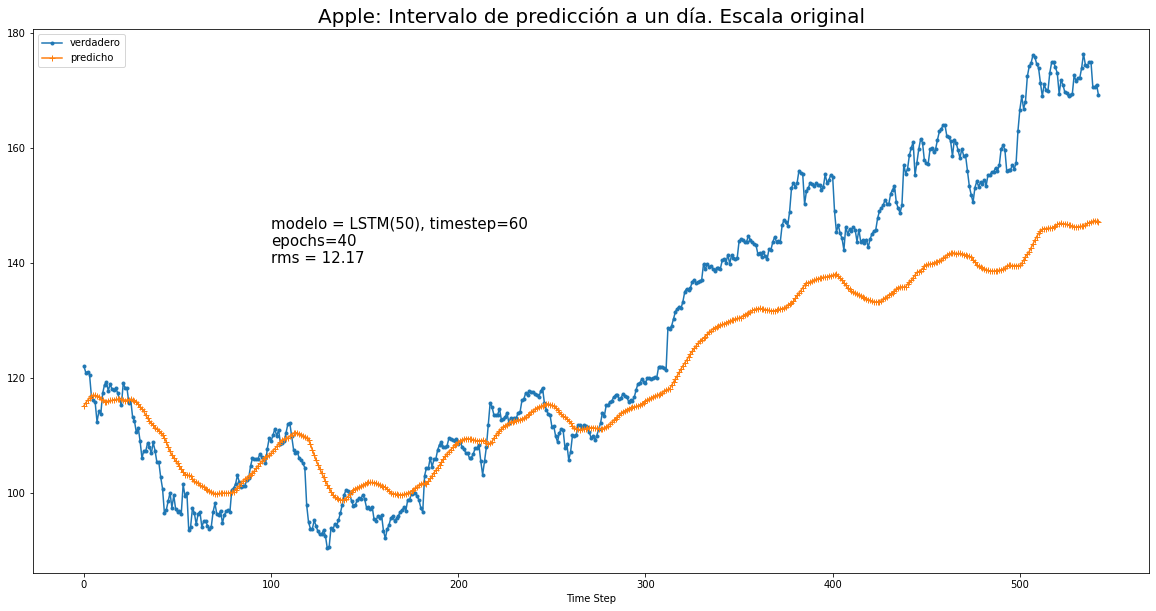

In [58]:
plt.plot(np.arange(0, len(y_test_or1)), y_test_or1, marker='.', label="verdadero")
plt.plot(np.arange(0, len(y_test_or1)), y_pred_or1, marker='+', label="predicho")
plt.xlabel('Time Step')
plt.annotate("rms = "+str(round(rmsLSTM,2)) , xy=(100, 140), size = 15)
plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
plt.annotate("epochs=40" , xy=(100, 143), size = 15)
plt.title("Apple: Intervalo de predicción a un día. Escala original", size = 20)
plt.legend()
plt.show();

## <span style="color:#4361EE">Guarda el modelo entrenado</span>

````{tab} Python
```python
model_01.save('../Datos/modelo_Apple_1_dia.h5')
```
````


## <span style="color:#4361EE">Intervalos de confianza. TO DO</span>

### <span style="color:#4CC9F0">Recupera la configuración del modelo</span>

In [59]:
model_01.get_config()

{'name': 'series_LSTM_model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 60, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_2'},
   'name': 'input_2',
   'inbound_nodes': []},
  {'class_name': 'Dropout',
   'config': {'name': 'Dropout_01',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.2,
    'noise_shape': None,
    'seed': None},
   'name': 'Dropout_01',
   'inbound_nodes': [[['input_2', 0, 0, {}]]]},
  {'class_name': 'LSTM',
   'config': {'name': 'LSTM_layer',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'shared_object_id': 2},
    'recurren

## <span style="color:#4361EE">Crea el modelo LSTM bidirecional</span>

In [60]:
# shapes
input_shape = (X_train.shape[1], X_train.shape[2])
units_2 = 64
dropout = 0.2

# layers
inputs = Input(input_shape)
x = Dropout(dropout, name= 'Dropout_01')(inputs)
x = Bidirectional(LSTM(units, return_sequences=True,dropout=dropout,
    recurrent_dropout=dropout,))(x)
x = Bidirectional(LSTM(units//4, dropout=dropout,
    recurrent_dropout=dropout,))(x)
x = Dropout(dropout, name= 'Dropout_02')(x)
outputs = Dense(1)(x)

# model
model_02 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_02.summary()


Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 Dropout_01 (Dropout)        (None, 60, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 60, 100)          20800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 24)               10848     
 nal)                                                            
                                                                 
 Dropout_02 (Dropout)        (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 1)           

### <span style="color:#4CC9F0">Compila</span>


Se usará el optimizador Adam y la función de pérdida MSE

In [61]:
model_02.compile(loss='mean_squared_error',
  optimizer=Adam(0.001),metrics=["mae"])


In [62]:
tf.random.set_seed(500)

history = model_02.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/10
34/34 [==============================] - 18s 179ms/step - loss: 0.0047 - mae: 0.0517 - val_loss: 0.0170 - val_mae: 0.1258
Epoch 2/10
34/34 [==============================] - 6s 170ms/step - loss: 0.0077 - mae: 0.0725 - val_loss: 0.0083 - val_mae: 0.0874
Epoch 3/10
34/34 [==============================] - 7s 198ms/step - loss: 0.0031 - mae: 0.0395 - val_loss: 0.0017 - val_mae: 0.0350
Epoch 4/10
34/34 [==============================] - 7s 206ms/step - loss: 0.0035 - mae: 0.0414 - val_loss: 0.0022 - val_mae: 0.0411
Epoch 5/10
34/34 [==============================] - 7s 216ms/step - loss: 0.0030 - mae: 0.0407 - val_loss: 0.0017 - val_mae: 0.0357
Epoch 6/10
34/34 [==============================] - 7s 209ms/step - loss: 0.0028 - mae: 0.0375 - val_loss: 0.0031 - val_mae: 0.0500
Epoch 7/10
34/34 [==============================] - 6s 185ms/step - loss: 0.0036 - mae: 0.0425 - val_loss: 9.9087e-04 - val_mae: 0.0252
Epoch 8/10
34/34 [==============================] - 8s 222ms/step - los

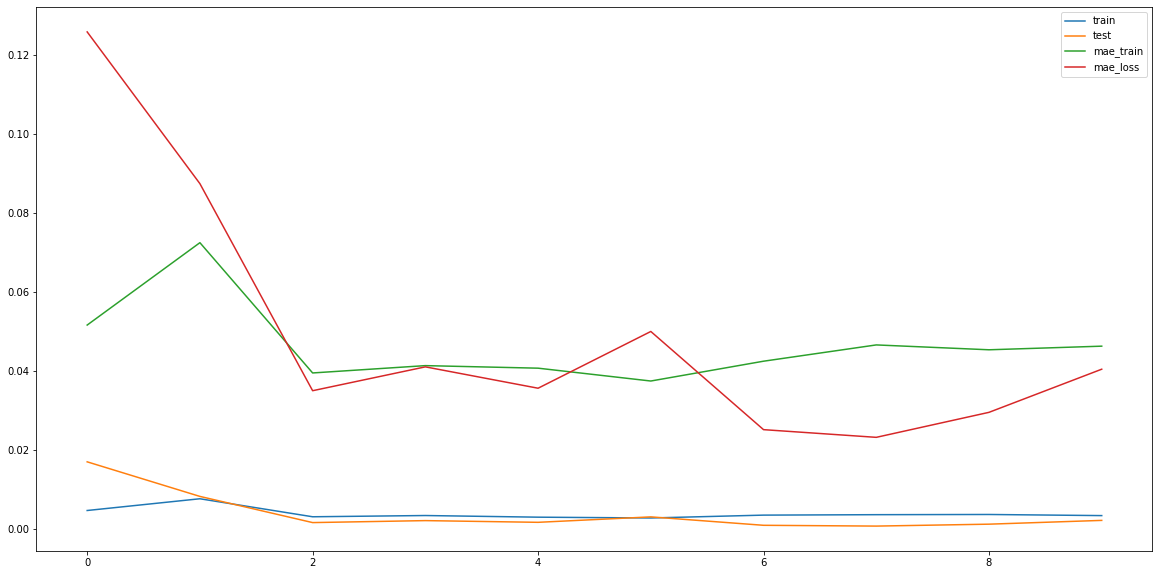

In [63]:
plt.plot(history.history['loss'][:], label='train')
plt.plot(history.history['val_loss'][:], label='test')
plt.plot(history.history['mae'][:], label='mae_train')
plt.plot(history.history['val_mae'][:], label='mae_loss')
plt.legend();

## <span style="color:#4361EE">Predicciones</span>

### <span style="color:#4CC9F0">Prepara los datos de validación</span>

In [64]:
X_test.shape

(543, 60, 1)

### <span style="color:#4CC9F0">Calcula predicciones</span>

In [65]:
# predictions
prediction2 = model_02.predict(X_test)
#prediction = scaler.inverse_transform(prediction)

17/17 [==============================] - 2s 26ms/step


In [66]:
print(prediction2.shape)
print(y_test.shape)


(543, 1)
(543,)


### <span style="color:#4CC9F0">Elimina dimensiones sobrante para los gráficos</span>

In [67]:
y_train_p2 = y_train #np.squeeze(y_train, axis=-1)
y_test_p2 = y_test#np.squeeze(y_test, axis=-1)
y_pred_p2 = np.squeeze(prediction2, axis=-1)

In [68]:
print(y_train_p2.shape)
print(y_test_p2.shape)
print(y_pred_p2.shape)

k=0
for i,j in zip(y_test_p2, y_pred_p2):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

(2355,)
(543,)
(543,)
0.6783307719588605 0.61679226 0.061538510358366105
0.6719470386570517 0.61782646 0.054120576865059555
0.6727745596406196 0.6188961 0.05387843289348826
0.6698782361981322 0.6195038 0.050374440097515794
0.6474169523584349 0.62001574 0.027401211963842598
0.6435157820073296 0.62032115 0.02319462741290823
0.6412105449816764 0.61981595 0.021394599356371224
0.6212318240926825 0.61928403 0.0019477903173529265
0.6321078141624307 0.6189245 0.013183315604386237
0.6292114907199433 0.61821944 0.010992055504946974


### <span style="color:#4CC9F0">Gráfica de las predicciones</span>

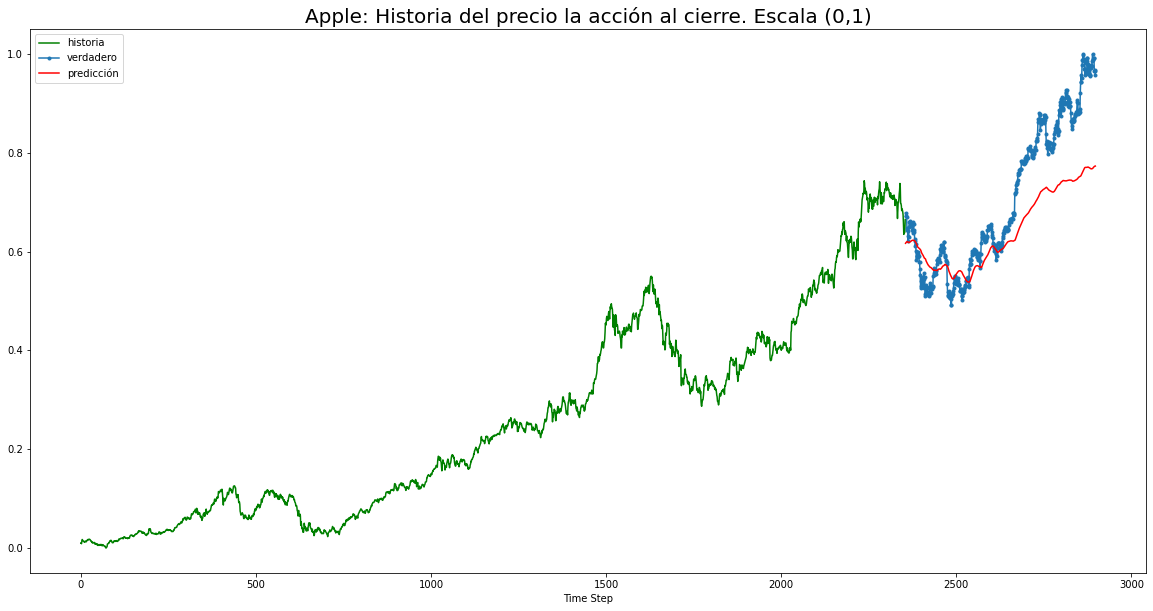

In [69]:
plt.plot(np.arange(0, len(y_train_p2)), y_train_p2, 'g', label="historia")
plt.plot(np.arange(len(y_train_p2), len(y_train_p2) + len(y_test_p2)), y_test_p2, marker='.', label="verdadero")
plt.plot(np.arange(len(y_train_p2), len(y_train_p2) + len(y_test_p2)), y_pred_p2, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Apple: Historia del precio la acción al cierre. Escala (0,1)", size = 20)
plt.legend()
plt.show();

### <span style="color:#4CC9F0">Regreso a la escala original</span>

In [70]:
y_pred_or2 = scaler.inverse_transform(y_pred_p2.reshape(-1,1))
y_test_or2 = scaler.inverse_transform(y_test_p2.reshape(-1,1))

In [71]:
k=0
for i,j in zip(y_test_or2, y_pred_or2):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

[122.] [111.58891] [10.41108704]
[120.92] [111.76388] [9.15612213]
[121.06] [111.94485] [9.11515289]
[120.57] [112.04765] [8.5223468]
[116.77] [112.13426] [4.63573792]
[116.11] [112.18593] [3.92407166]
[115.72] [112.10046] [3.61954376]
[112.34] [112.01047] [0.32953247]
[114.18] [111.949646] [2.230354]
[113.69] [111.83036] [1.85963959]


In [72]:
rmsLSTM = np.sqrt(np.mean(np.power(y_pred_or2-y_test_or2,2)))
print(rmsLSTM )

16.754417648439286


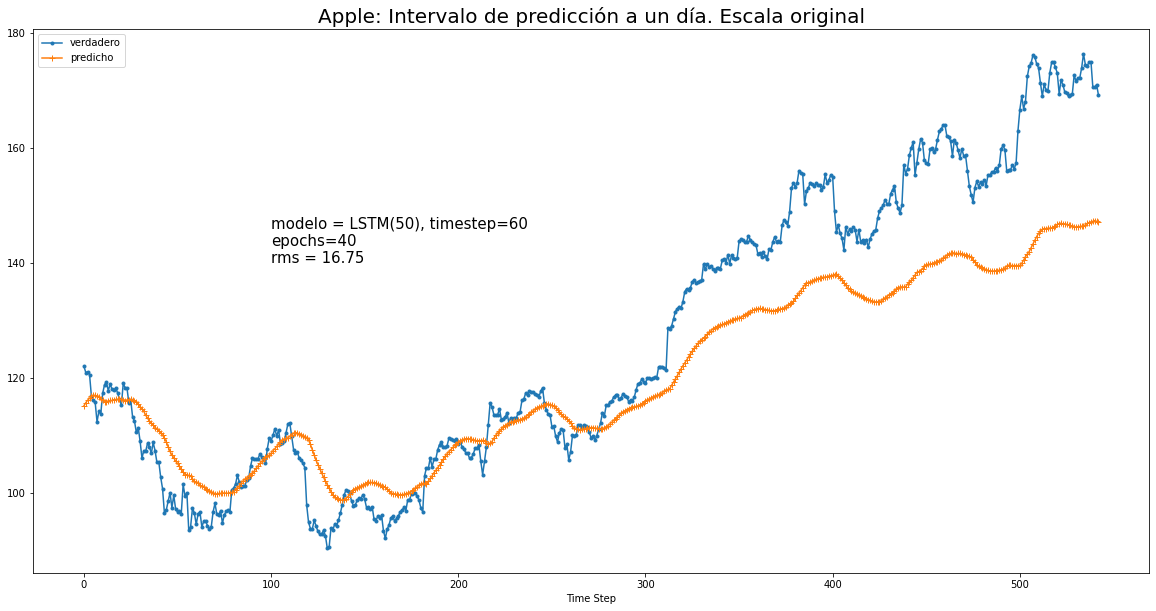

In [74]:
plt.plot(np.arange(0, len(y_test_or1)), y_test_or1, marker='.', label="verdadero")
plt.plot(np.arange(0, len(y_test_or1)), y_pred_or1, marker='+', label="predicho")
plt.xlabel('Time Step')
plt.annotate("rms = "+str(round(rmsLSTM,2)) , xy=(100, 140), size = 15)
plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
plt.annotate("epochs=40" , xy=(100, 143), size = 15)
plt.title("Apple: Intervalo de predicción a un día. Escala original", size = 20)
plt.legend()
plt.show();

## <span style="color:#4361EE">Referencias</span>

1. [Introducción a Redes LSTM](Intro_LSTM.ipynb)
1. [Time Series Forecasting with LSTMs using TensorFlow 2 and Keras in Python](https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651/)
1. [Dive into Deep Learnig](https://d2l.ai/)
1. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
1. Ralf C. Staudemeyer and Eric Rothstein Morris,[*Understanding LSTM a tutorial into Long Short-Term Memory Recurrent Neural Networks*](https://arxiv.org/pdf/1909.09586.pdf), arxiv, September 2019
1. Karpathy, [*The Unreasonable Effectiveness of Recurrent Neural Networks*](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
1. Anton Lucanus, [Making Automation More Efficient by Learning from Historical Trade Data](https://datafloq.com/read/making-automation-more-efficient-by-learning-from-/7444), 8:43 AM, January 7, 2020
1. https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
1. https://www.youtube.com/watch?v=2BrpKpWwT2A&list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ&index=1
1. https://towardsdatascience.com/using-lstms-for-stock-market-predictions-tensorflow-9e83999d4653
1. https://github.com/llSourcell/Reinforcement_Learning_for_Stock_Prediction/blob/master/README.md